In [2]:
# 標準
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import STL
import itertools
import scipy.stats
import time
# 自作
import my_function
import time_dependent_tree
import graft_regression_tree

In [3]:
# テストデータ設定部

np.random.seed(314) # 乱数シードを314に設定
# 合成波の作成
syn_t = my_function.make_wave(0.5, 1.0, 3.0, 100)[0]
syn_y = my_function.make_wave(0.5, 1.0, 3.0, 100)[1] + my_function.make_wave(0.75, 1.7, 3.0, 100)[1] + 0.05 * np.random.randn(len(syn_t))
syn_y = scipy.stats.zscore(syn_y)
print("size：",len(syn_y))

size： 300


In [3]:
# パラメータ等の設定
raw_array = syn_y
max_depth = 5

In [4]:
# STL分解
stl=STL(raw_array, period=12, robust=True)
stl_series = stl.fit()
# STL分解結果のグラフ化
"""
plt.rcParams['figure.figsize'] = [12, 9]
stl_series.plot()
plt.show()
"""

"\nplt.rcParams['figure.figsize'] = [12, 9]\nstl_series.plot()\nplt.show()\n"

In [5]:
# データの整形
raw_x, raw_y = my_function.sliding_window(raw_array)
trend_x, trend_y = my_function.sliding_window(stl_series.trend)
seasonal_x, seasonal_y = my_function.sliding_window(stl_series.seasonal)
resid_x, resid_y = my_function.sliding_window(stl_series.resid)

# データの分割
raw_x_train, raw_x_test, raw_y_train, raw_y_test = train_test_split(raw_x, raw_y, test_size=0.1, shuffle=False)
trend_x_train, trend_x_test, trend_y_train, trend_y_test = train_test_split(trend_x, trend_y, test_size=0.1, shuffle=False)
seasonal_x_train, seasonal_x_test, seasonal_y_train, seasonal_y_test = train_test_split(seasonal_x, seasonal_y, test_size=0.1, shuffle=False)
resid_x_train, resid_x_test, resid_y_train, resid_y_test = train_test_split(resid_x, resid_y, test_size=0.1, shuffle=False)

### 時間依存木 - TDTree

In [6]:
# インスタンス生成
trend_tdtree = time_dependent_tree.TimeDependentTree(trend_x_train, raw_y_train, max_depth=max_depth, min_samples_leaf=5)
seasonal_tdtree = time_dependent_tree.TimeDependentTree(seasonal_x_train, raw_y_train, max_depth=max_depth, min_samples_leaf=5)
resid_tdtree = time_dependent_tree.TimeDependentTree(resid_x_train, raw_y_train, max_depth=max_depth, min_samples_leaf=5)

# 処理前の時刻
t1 = time.time() 

# 学習
trend_tdtree.train()
seasonal_tdtree.train()
resid_tdtree.train()

# 処理後の時刻
t2 = time.time()
# 経過時間を表示
elapsed_time = t2-t1
print(f"経過時間：{elapsed_time}")

# 予測
trend_train_pred = trend_tdtree.predict(trend_x_train)
trend_test_pred = trend_tdtree.predict(trend_x_test)
seasonal_train_pred = seasonal_tdtree.predict(seasonal_x_train)
seasonal_test_pred = seasonal_tdtree.predict(seasonal_x_test)
resid_train_pred = resid_tdtree.predict(resid_x_train)
resid_test_pred = resid_tdtree.predict(resid_x_test)

経過時間：0.3130605220794678


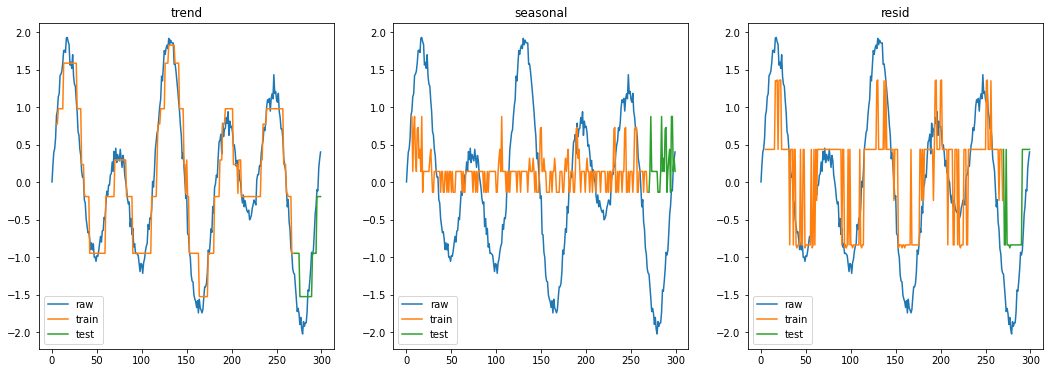

In [7]:
# 時間依存木の予測結果の描画

#グラフを表示する領域を，figオブジェクトとして作成。
fig = plt.figure(figsize = (18,6))

#グラフを描画するsubplot領域を作成。
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.plot(range(0, len(raw_array)), raw_array, label='raw')
ax1.plot(range(max_depth, len(trend_train_pred)+5), trend_train_pred, label='train')
ax1.plot(range(len(raw_array)-len(trend_test_pred), len(raw_array)), trend_test_pred, label='test')
ax1.set_title('trend')
ax1.legend()

ax2.plot(range(0, len(raw_array)), raw_array, label='raw')
ax2.plot(range(max_depth, len(seasonal_train_pred)+5), seasonal_train_pred, label='train')
ax2.plot(range(len(raw_array)-len(seasonal_test_pred), len(raw_array)), seasonal_test_pred, label='test')
ax2.set_title('seasonal')
ax2.legend()

ax3.plot(range(0, len(raw_array)), raw_array, label='raw')
ax3.plot(range(max_depth, len(resid_train_pred)+5), resid_train_pred, label='train')
ax3.plot(range(len(raw_array)-len(resid_test_pred), len(raw_array)), resid_test_pred, label='test')
ax3.set_title('resid')
ax3.legend()

plt.show()

### Graft Regression Tree - GRTree

In [8]:
# データのまとめ
x_train_ls = [trend_x_train, seasonal_x_train, resid_x_train]
x_test_ls = [trend_x_test, seasonal_x_test, resid_x_test]
tdtree_ls = [trend_tdtree, seasonal_tdtree, resid_tdtree]

tdtree_index_ls = []
grid_iter = itertools.product(range(3), repeat=5)
for a, b, c, d, e in grid_iter:
    tdtree_index_ls.append([a, b, c, d, e])

eval_ls = []

In [9]:
# Graft Regression Tree
grtree = graft_regression_tree.GraftRegressionTree(tdtree_ls)

# 処理前の時刻
t1 = time.time() 

for tdtree_index in tdtree_index_ls:
    grtree.build_tree(tdtree_index_ls=tdtree_index)
    grtree_train_pred = grtree.predict(x_train_ls)
    eval_ls.append(grtree.evalution(y_true=raw_y_train, y_pred=grtree_train_pred, method="mse"))
    
# 処理後の時刻
t2 = time.time()
# 経過時間を表示
elapsed_time = t2-t1
print(f"経過時間：{elapsed_time}")

経過時間：13.251293182373047


In [10]:
def output_eval_and_index(ls, eval_type):
    sort_ls = np.sort(ls)
    argsort_ls = np.argsort(ls)
    if eval_type == "best":
        return sort_ls[0:3], argsort_ls[0:3]
    if eval_type == "worst":
        return sort_ls[-4:-1], argsort_ls[-4:-1]

In [11]:
best_eval_ls, best_index_ls = output_eval_and_index(eval_ls, eval_type="best")
worst_eval_ls, worst_index_ls = output_eval_and_index(eval_ls, eval_type="worst")

print('best：', best_eval_ls)
print('worst：', worst_eval_ls)

best： [0.08087142 0.17422543 0.17605553]
worst： [3.19556528 3.19556528 3.19556528]


[0, 0, 0, 0, 0]


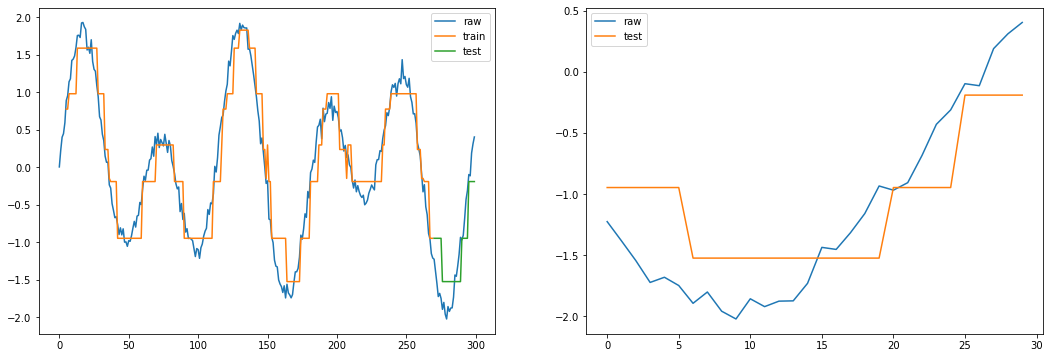

In [12]:
print(tdtree_index_ls[best_index_ls[0]])
grtree.build_tree(tdtree_index_ls=tdtree_index_ls[best_index_ls[0]])
grtree_train_pred = grtree.predict(x_train_ls)
grtree_test_pred = grtree.predict(x_test_ls)

#グラフを表示する領域を，figオブジェクトとして作成。
fig = plt.figure(figsize = (18,6))

#グラフを描画するsubplot領域を作成。
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(range(0, len(raw_array)), raw_array, label='raw')
ax1.plot(range(max_depth, len(grtree_train_pred)+max_depth), grtree_train_pred, label='train')
ax1.plot(range(len(raw_array)-len(grtree_test_pred), len(raw_array)), grtree_test_pred, label='test')
ax1.legend()

ax2.plot(raw_y_test, label='raw')
ax2.plot(grtree_test_pred, label='test')
ax2.legend()

plt.show()

[2, 0, 0, 0, 0]


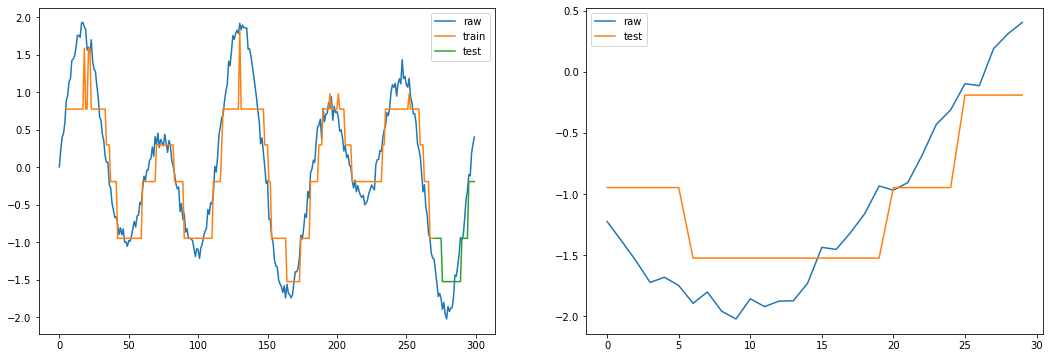

In [13]:
print(tdtree_index_ls[best_index_ls[1]])
grtree.build_tree(tdtree_index_ls=tdtree_index_ls[best_index_ls[1]])
grtree_train_pred = grtree.predict(x_train_ls)
grtree_test_pred = grtree.predict(x_test_ls)

#グラフを表示する領域を，figオブジェクトとして作成。
fig = plt.figure(figsize = (18,6))

#グラフを描画するsubplot領域を作成。
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(range(0, len(raw_array)), raw_array, label='raw')
ax1.plot(range(max_depth, len(grtree_train_pred)+max_depth), grtree_train_pred, label='train')
ax1.plot(range(len(raw_array)-len(grtree_test_pred), len(raw_array)), grtree_test_pred, label='test')
ax1.legend()

ax2.plot(raw_y_test, label='raw')
ax2.plot(grtree_test_pred, label='test')
ax2.legend()

plt.show()

[0, 0, 0, 0, 2]


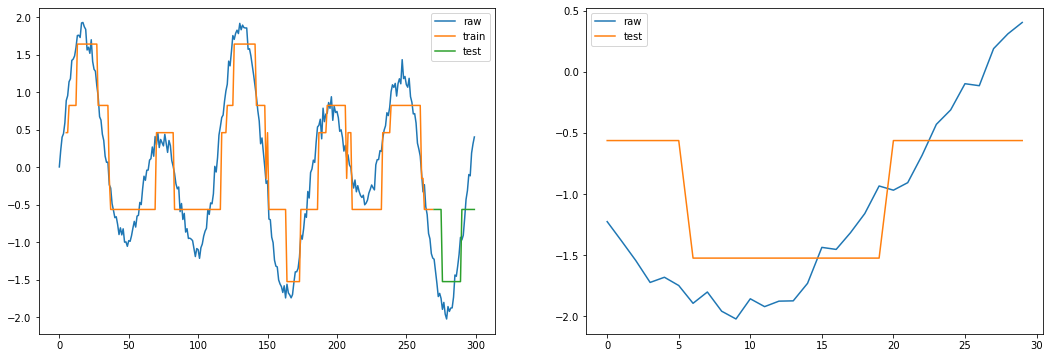

In [14]:
print(tdtree_index_ls[best_index_ls[2]])
grtree.build_tree(tdtree_index_ls=tdtree_index_ls[best_index_ls[2]])
grtree_train_pred = grtree.predict(x_train_ls)
grtree_test_pred = grtree.predict(x_test_ls)

#グラフを表示する領域を，figオブジェクトとして作成。
fig = plt.figure(figsize = (18,6))

#グラフを描画するsubplot領域を作成。
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(range(0, len(raw_array)), raw_array, label='raw')
ax1.plot(range(max_depth, len(grtree_train_pred)+max_depth), grtree_train_pred, label='train')
ax1.plot(range(len(raw_array)-len(grtree_test_pred), len(raw_array)), grtree_test_pred, label='test')
ax1.legend()

ax2.plot(raw_y_test, label='raw')
ax2.plot(grtree_test_pred, label='test')
ax2.legend()

plt.show()

[2, 2, 0, 2, 2]


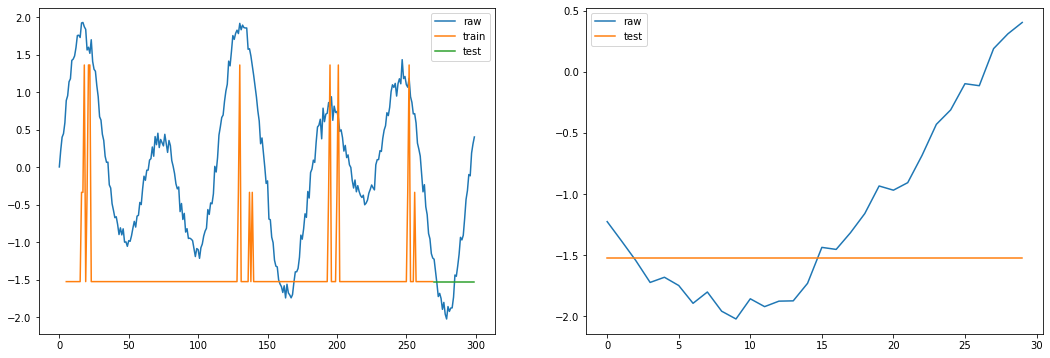

In [15]:
print(tdtree_index_ls[worst_index_ls[2]])
grtree.build_tree(tdtree_index_ls=tdtree_index_ls[worst_index_ls[2]])
grtree_train_pred = grtree.predict(x_train_ls)
grtree_test_pred = grtree.predict(x_test_ls)

#グラフを表示する領域を，figオブジェクトとして作成。
fig = plt.figure(figsize = (18,6))

#グラフを描画するsubplot領域を作成。
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(range(0, len(raw_array)), raw_array, label='raw')
ax1.plot(range(max_depth, len(grtree_train_pred)+max_depth), grtree_train_pred, label='train')
ax1.plot(range(len(raw_array)-len(grtree_test_pred), len(raw_array)), grtree_test_pred, label='test')
ax1.legend()

ax2.plot(raw_y_test, label='raw')
ax2.plot(grtree_test_pred, label='test')
ax2.legend()

plt.show()

[2, 2, 0, 1, 0]


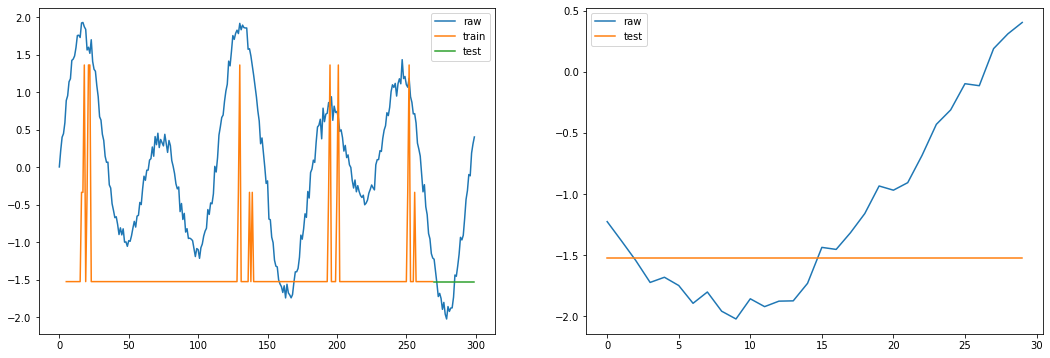

In [16]:
print(tdtree_index_ls[worst_index_ls[1]])
grtree.build_tree(tdtree_index_ls=tdtree_index_ls[worst_index_ls[1]])
grtree_train_pred = grtree.predict(x_train_ls)
grtree_test_pred = grtree.predict(x_test_ls)

#グラフを表示する領域を，figオブジェクトとして作成。
fig = plt.figure(figsize = (18,6))

#グラフを描画するsubplot領域を作成。
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(range(0, len(raw_array)), raw_array, label='raw')
ax1.plot(range(max_depth, len(grtree_train_pred)+max_depth), grtree_train_pred, label='train')
ax1.plot(range(len(raw_array)-len(grtree_test_pred), len(raw_array)), grtree_test_pred, label='test')
ax1.legend()

ax2.plot(raw_y_test, label='raw')
ax2.plot(grtree_test_pred, label='test')
ax2.legend()

plt.show()

[2, 2, 0, 1, 2]


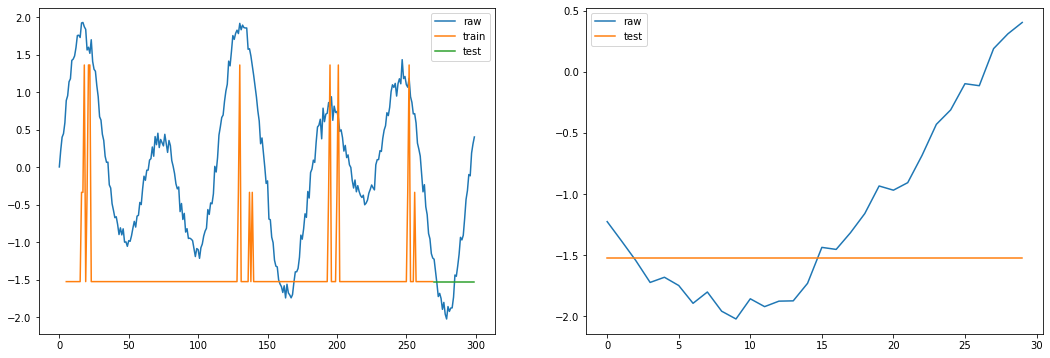

In [17]:
print(tdtree_index_ls[worst_index_ls[0]])
grtree.build_tree(tdtree_index_ls=tdtree_index_ls[worst_index_ls[0]])
grtree_train_pred = grtree.predict(x_train_ls)
grtree_test_pred = grtree.predict(x_test_ls)

#グラフを表示する領域を，figオブジェクトとして作成。
fig = plt.figure(figsize = (18,6))

#グラフを描画するsubplot領域を作成。
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(range(0, len(raw_array)), raw_array, label='raw')
ax1.plot(range(max_depth, len(grtree_train_pred)+max_depth), grtree_train_pred, label='train')
ax1.plot(range(len(raw_array)-len(grtree_test_pred), len(raw_array)), grtree_test_pred, label='test')
ax1.legend()

ax2.plot(raw_y_test, label='raw')
ax2.plot(grtree_test_pred, label='test')
ax2.legend()

plt.show()